In [1]:
import numpy as np
import pandas as pd
import re

from matplotlib import pyplot as plt
from scipy.stats import beta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict

%matplotlib inline

# Exploration

In [2]:
df = pd.read_csv('../data/digitiser_dataset.csv', index_col=0)
df = df[df['x_questions']==20]
df.head(10)

,feedback,name,question,round,best_of_name,model_id,user_id,x_questions
0,-1,Lio,1,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
1,-1,Sara,1,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
2,3,Marilou,1,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
3,-1,Chloé,1,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
4,-1,Iluna,2,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
5,3,Mira,2,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
6,-1,Zoë,2,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
7,-1,Helena,2,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
8,-1,June,3,1,False,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20
9,3,Léa,3,1,True,3dxqYZDIqnnbnJRwd9xF,x7cU2PT7nm4vlv41PTd4,20


In [3]:
views = df['name'].value_counts()
views.head()

Anna     3164
Zoé      3071
Lou      2898
Laura    2897
Elize    2894
Name: name, dtype: int64

In [4]:
clicks = df.loc[df['feedback']==3,'name'].value_counts()
clicks.head()

Anna    1224
Lou     1205
Nora    1203
Lili    1159
Ella    1112
Name: name, dtype: int64

In [5]:
clicks_per_view = clicks / views
name_df = pd.DataFrame({'clicks':clicks, 'views':views, 'clicks_per_view':clicks_per_view})
name_df.sort_values('clicks_per_view', ascending=False).head()

,clicks,clicks_per_view,views
Charlie,1.0,1.000000,1
Minne,2.0,0.666667,3
Annabelle,2.0,0.666667,3
Ella,1112.0,0.555445,2002
Nore,501.0,0.524059,956


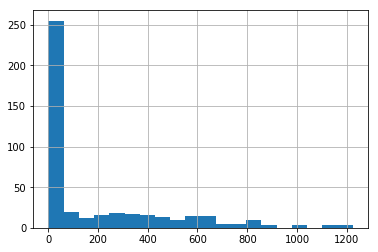

In [6]:
name_df['clicks'].hist(bins=20)

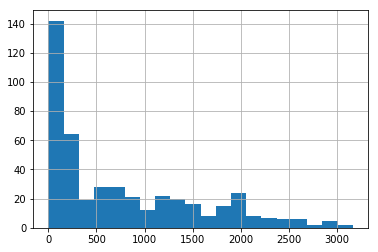

In [7]:
name_df['views'].hist(bins=20)

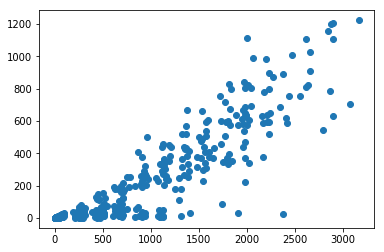

In [8]:
plt.scatter(name_df['views'], name_df['clicks'])

# Bayesian clicks per view

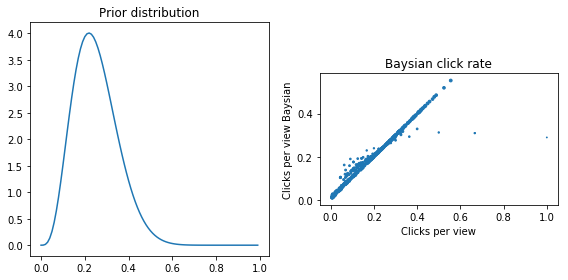

In [9]:
# Get the occurence dataframe
name_df['clicks'] = name_df['clicks'].fillna(0)

# Calcultate parameters of the priors
mu = 0.25
var = 0.06
prior_a = np.power(((1. - mu) / var - 1. / mu) * mu , 2)
prior_b = prior_a * (1. / mu - 1.)

x = np.arange(0, 1, 0.01)
distribution = beta.pdf(x, prior_a, prior_b)

def calculate_baysian_mean(views, clicks):
    non_clicks = views - clicks
    if(views==0): print('no views')
    mean, var, skew, kurt = beta.stats(prior_a + clicks, prior_b + non_clicks, moments='mvsk')
    return mean

# Calculate for each name the baysian clicks per view
name_df['clicks_per_view_baysian'] = name_df.apply(lambda row: calculate_baysian_mean(row['views'], row['clicks']), axis=1)
name_df['clicks_per_view_baysian'] = name_df['clicks_per_view_baysian'].astype(float)

# Some plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

axes[0].plot(x, distribution)
axes[0].set_title('Prior distribution')

axes[1].scatter(name_df['clicks_per_view'], name_df['clicks_per_view_baysian'], s=np.log(name_df['views']+1))
axes[1].set_title('Baysian click rate')
axes[1].set_xlabel('Clicks per view')
axes[1].set_ylabel('Clicks per view Baysian')
axes[1].set_aspect('equal')

fig.tight_layout()



# Baseline


In [10]:
popularity = pd.read_csv('../data/popularity.csv')
popularity.head()

,name,sex,region,year_1995,year_1996,year_1997,year_1998,year_1999,year_2000,year_2001,...,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016
0,Aagje,F,Vlaanderen,0.0,10.0,7.0,6.0,5.0,0.0,12.0,...,10.0,11.0,12.0,11.0,8.0,11.0,7.0,0.0,0.0,0.0
1,Aaliyah,F,Vlaanderen,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,8.0,7.0,14.0,9.0,9.0,7.0,10.0,11.0,8.0,13.0
2,Abigail,F,Vlaanderen,0.0,0.0,8.0,0.0,0.0,0.0,5.0,...,0.0,6.0,7.0,8.0,16.0,11.0,10.0,10.0,11.0,12.0
3,Ada,F,Vlaanderen,0.0,0.0,0.0,0.0,5.0,0.0,6.0,...,12.0,19.0,17.0,20.0,24.0,19.0,28.0,32.0,35.0,27.0
4,Adeline,F,Vlaanderen,15.0,10.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,6.0,8.0,0.0,8.0,0.0,12.0


In [11]:
df['question_id'] = df['model_id'] + '_' + df['question'].astype(str)
df['question_id'].head(12)

0     3dxqYZDIqnnbnJRwd9xF_1
1     3dxqYZDIqnnbnJRwd9xF_1
2     3dxqYZDIqnnbnJRwd9xF_1
3     3dxqYZDIqnnbnJRwd9xF_1
4     3dxqYZDIqnnbnJRwd9xF_2
5     3dxqYZDIqnnbnJRwd9xF_2
6     3dxqYZDIqnnbnJRwd9xF_2
7     3dxqYZDIqnnbnJRwd9xF_2
8     3dxqYZDIqnnbnJRwd9xF_3
9     3dxqYZDIqnnbnJRwd9xF_3
10    3dxqYZDIqnnbnJRwd9xF_3
11    3dxqYZDIqnnbnJRwd9xF_3
Name: question_id, dtype: object

In [12]:
most_popular = (
    pd.merge(
        df, 
        popularity, 
        left_on = 'name', 
        right_on = 'name')
     .sort_values('year_2016', ascending=False)
     .groupby('question_id')['name'].first())
clicked = df.sort_values('feedback', ascending=False).groupby('question_id')['name'].first()

In [13]:
most_popular.head()

question_id
00329XrhSh1vtc7swjcP_1     Lucie
00329XrhSh1vtc7swjcP_11    Emily
00329XrhSh1vtc7swjcP_12     Lore
00329XrhSh1vtc7swjcP_13     Emma
00329XrhSh1vtc7swjcP_14     Ella
Name: name, dtype: object

In [14]:
clicked.head()

question_id
00329XrhSh1vtc7swjcP_1        Mona
00329XrhSh1vtc7swjcP_11    Paulien
00329XrhSh1vtc7swjcP_12       Maya
00329XrhSh1vtc7swjcP_13    Phaedra
00329XrhSh1vtc7swjcP_14        Zoé
Name: name, dtype: object

In [15]:
questions = pd.DataFrame({'most_popular':most_popular, 'clicked':clicked})
questions.head()

,clicked,most_popular
question_id,,
00329XrhSh1vtc7swjcP_1,Mona,Lucie
00329XrhSh1vtc7swjcP_11,Paulien,Emily
00329XrhSh1vtc7swjcP_12,Maya,Lore
00329XrhSh1vtc7swjcP_13,Phaedra,Emma
00329XrhSh1vtc7swjcP_14,Zoé,Ella


In [16]:
(questions['clicked'] == questions['most_popular']).mean()

0.36012228260869567

The popularity based recommender guesses clicks correctly **36%** of the time

# Content-based recommender

## Modeling for a single user

In [17]:
feature_df = pd.read_csv('../data/features.csv', index_col=0)

In [18]:
df['target'] = df['feedback'].map({-1:0, 3:1})

In [19]:
model_id = df['model_id'].sample().iloc[0]
model_df = pd.merge(df[df['model_id']==model_id], feature_df, on='name')
model_df.head(12)

,feedback,name,question,round,best_of_name,model_id,user_id,x_questions,question_id,target,...,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016
0,3,Lize,1,1,False,pqlfkghzWvmWO3nA1VEt,TxcrHPvpURD3clSJvK6k,20,pqlfkghzWvmWO3nA1VEt_1,1,...,51.0,46.0,35.0,46.0,76.0,75.0,67.0,92.0,78.0,85.0
1,-1,Roxanne,1,1,False,pqlfkghzWvmWO3nA1VEt,TxcrHPvpURD3clSJvK6k,20,pqlfkghzWvmWO3nA1VEt_1,0,...,10.0,8.0,18.0,22.0,24.0,27.0,24.0,30.0,28.0,41.0
2,-1,Marieke,1,1,False,pqlfkghzWvmWO3nA1VEt,TxcrHPvpURD3clSJvK6k,20,pqlfkghzWvmWO3nA1VEt_1,0,...,47.0,24.0,25.0,33.0,33.0,21.0,22.0,20.0,9.0,9.0
3,-1,Juliette,1,1,False,pqlfkghzWvmWO3nA1VEt,TxcrHPvpURD3clSJvK6k,20,pqlfkghzWvmWO3nA1VEt_1,0,...,76.0,113.0,122.0,109.0,144.0,169.0,163.0,173.0,249.0,210.0
4,-1,Imane,2,1,False,pqlfkghzWvmWO3nA1VEt,TxcrHPvpURD3clSJvK6k,20,pqlfkghzWvmWO3nA1VEt_2,0,...,47.0,41.0,39.0,37.0,33.0,41.0,31.0,20.0,17.0,22.0
5,-1,Josefien,2,1,False,pqlfkghzWvmWO3nA1VEt,TxcrHPvpURD3clSJvK6k,20,pqlfkghzWvmWO3nA1VEt_2,0,...,23.0,19.0,21.0,15.0,21.0,21.0,26.0,23.0,25.0,36.0
6,-1,Laura,2,1,False,pqlfkghzWvmWO3nA1VEt,TxcrHPvpURD3clSJvK6k,20,pqlfkghzWvmWO3nA1VEt_2,0,...,228.0,222.0,196.0,209.0,203.0,179.0,170.0,165.0,139.0,123.0
7,3,Elle,2,1,True,pqlfkghzWvmWO3nA1VEt,TxcrHPvpURD3clSJvK6k,20,pqlfkghzWvmWO3nA1VEt_2,1,...,21.0,32.0,38.0,30.0,40.0,39.0,27.0,38.0,45.0,31.0
8,3,Alix,3,1,False,pqlfkghzWvmWO3nA1VEt,TxcrHPvpURD3clSJvK6k,20,pqlfkghzWvmWO3nA1VEt_3,1,...,20.0,27.0,28.0,31.0,44.0,30.0,38.0,33.0,32.0,41.0
9,-1,Margo,3,1,False,pqlfkghzWvmWO3nA1VEt,TxcrHPvpURD3clSJvK6k,20,pqlfkghzWvmWO3nA1VEt_3,0,...,35.0,25.0,44.0,24.0,23.0,21.0,19.0,22.0,21.0,14.0


In [20]:
features = ['score_classic', 'dtw_vlaanderen_1',
       'dtw_vlaanderen_2', 'score_typical_vl', 'score_typical_wal',
       'score_typical_bxl']

In [21]:
X = model_df[features]
y = model_df['target']

In [22]:
clf = RandomForestClassifier()

In [23]:
param_grid = {'n_estimators':[10, 30, 60, 100, 200], 'max_depth':[2, 3, 4]}
clf_gs = GridSearchCV(clf,param_grid=param_grid, cv=3, n_jobs=-1)
clf_gs.fit(X,y)
clf_gs.best_params_

{'max_depth': 2, 'n_estimators': 10}

In [24]:
cv_results = pd.DataFrame(clf_gs.cv_results_)
cv_results

/Users/carettem/anaconda/envs/pcp-env/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/carettem/anaconda/envs/pcp-env/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/carettem/anaconda/envs/pcp-env/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **w

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.061059,0.008276,0.765625,0.796973,2,10,"{'n_estimators': 10, 'max_depth': 2}",1,0.727273,0.809524,0.809524,0.790698,0.761905,0.790698,0.009482,0.005552,0.033801,0.008875
1,0.167255,0.010433,0.734375,0.804540,2,30,"{'n_estimators': 30, 'max_depth': 2}",3,0.727273,0.785714,0.761905,0.744186,0.714286,0.883721,0.017898,0.001997,0.019961,0.058500
2,0.301329,0.015812,0.703125,0.827981,2,60,"{'n_estimators': 60, 'max_depth': 2}",10,0.727273,0.809524,0.761905,0.790698,0.619048,0.883721,0.006552,0.000950,0.060445,0.040157
3,0.480951,0.023639,0.703125,0.820229,2,100,"{'n_estimators': 100, 'max_depth': 2}",10,0.727273,0.809524,0.761905,0.767442,0.619048,0.883721,0.004404,0.002693,0.060445,0.048070
4,0.964779,0.053699,0.718750,0.820229,2,200,"{'n_estimators': 200, 'max_depth': 2}",6,0.727273,0.809524,0.761905,0.767442,0.666667,0.883721,0.018225,0.002514,0.039066,0.048070
5,0.053203,0.002738,0.718750,0.890735,3,10,"{'n_estimators': 10, 'max_depth': 3}",6,0.727273,0.904762,0.809524,0.860465,0.619048,0.906977,0.009605,0.000170,0.077398,0.021423
6,0.155702,0.006326,0.703125,0.913990,3,30,"{'n_estimators': 30, 'max_depth': 3}",10,0.727273,0.904762,0.761905,0.930233,0.619048,0.906977,0.001867,0.000417,0.060445,0.011520
7,0.292166,0.017169,0.734375,0.898487,3,60,"{'n_estimators': 60, 'max_depth': 3}",3,0.727273,0.904762,0.761905,0.883721,0.714286,0.906977,0.002773,0.003514,0.019961,0.010480
8,0.488799,0.027892,0.718750,0.906423,3,100,"{'n_estimators': 100, 'max_depth': 3}",6,0.727273,0.928571,0.809524,0.883721,0.619048,0.906977,0.015860,0.002258,0.077398,0.018314
9,1.031825,0.044678,0.703125,0.898487,3,200,"{'n_estimators': 200, 'max_depth': 3}",10,0.727273,0.904762,0.761905,0.883721,0.619048,0.906977,0.055672,0.009127,0.060445,0.010480


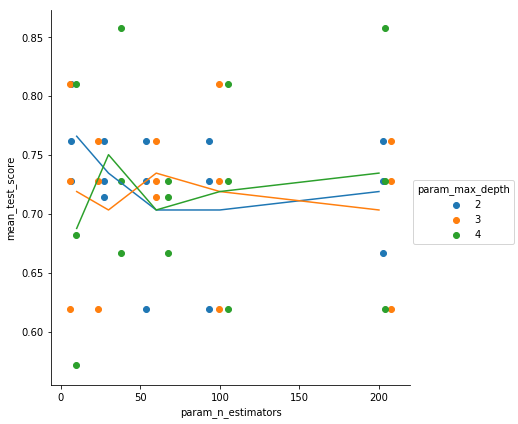

In [25]:
import seaborn as sns
g = sns.FacetGrid(cv_results, hue = 'param_max_depth', size = 6)
# xlim = (cv_results['param_n_estimators'].min(), cv_results['param_n_estimators'].max())
cv_results['param_n_estimators_jitter'] = cv_results['param_n_estimators'] + np.random.uniform(-10,10,size=len(cv_results))
for col in cv_results.columns:
    if re.search('split[0-9]_test_score', col):
        
        g.map(plt.scatter, 'param_n_estimators_jitter', col)
g.map(plt.plot, 'param_n_estimators', 'mean_test_score')
g.add_legend()
plt.show()


## Find top 30

In [26]:
X_other = feature_df.loc[~feature_df['name'].isin(model_df['name']), features]
name_other = feature_df.loc[~feature_df['name'].isin(model_df['name']), 'name']

In [27]:
best_clf = clf_gs.best_estimator_
y_other = best_clf.predict_proba(X_other)[:,1]

In [28]:
results = pd.DataFrame({'name':name_other, 'score':y_other})

In [29]:
results.sort_values('score', ascending=False)['name'].head(30)

362        Fran
653        Lina
414      Helena
793       Merel
625      Leonie
328      Fatima
143          Bo
253       Elien
632        Lien
334        Febe
983       Silke
688       Lotte
403       Hanne
339       Femke
345        Fien
146       Britt
559        Kato
547        Kaat
489       Janne
520      Jolien
798       Meyra
248       Elena
906       Renée
920        Roos
766      Marthe
914    Romaissa
816       Miray
93      Arianna
776       Maysa
775        Maya
Name: name, dtype: object

## Estimate model performance

In [30]:
cv_score = cross_val_predict(best_clf,X,y, cv=4,n_jobs=-1, method='predict_proba')[:,1]

In [31]:
model_df['cv_score'] = cv_score

In [32]:
%time best_score = (model_df.sort_values('cv_score', ascending=False).groupby('question_id')['name'].first())
%time clicked = model_df.sort_values('feedback', ascending=False).groupby('question_id')['name'].first()

CPU times: user 4.37 ms, sys: 3.18 ms, total: 7.56 ms
Wall time: 6.98 ms
CPU times: user 2.86 ms, sys: 300 µs, total: 3.16 ms
Wall time: 3.51 ms


In [33]:
questions = pd.DataFrame({'best_score':best_score, 'clicked':clicked})
questions

,best_score,clicked
question_id,,
pqlfkghzWvmWO3nA1VEt_1,Lize,Lize
pqlfkghzWvmWO3nA1VEt_11,Nona,Emilia
pqlfkghzWvmWO3nA1VEt_12,Floor,Floor
pqlfkghzWvmWO3nA1VEt_13,Nele,Nora
pqlfkghzWvmWO3nA1VEt_14,Fee,Mila
pqlfkghzWvmWO3nA1VEt_16,Luna,Luna
pqlfkghzWvmWO3nA1VEt_17,Estée,Anna
pqlfkghzWvmWO3nA1VEt_18,Ella,Ella
pqlfkghzWvmWO3nA1VEt_19,Esmee,Ellie


In [34]:
(questions['clicked'] == questions['best_score']).mean()

0.3125

## Estimate performance on many users

In [35]:
correctness = {}
for model_id in df['model_id'].drop_duplicates().sample(50):
    model_df = pd.merge(df[df['model_id']==model_id], feature_df, on='name', how='inner')
    X = model_df[features]
    y = model_df['target']
    #clf_gs.fit(X,y)
    cv_score = cross_val_predict(best_clf,X,y, cv=3, method='predict_proba', n_jobs=-1)[:,1]
    model_df['cv_score'] = cv_score
    best_score = (model_df.sort_values('cv_score', ascending=False).groupby('question_id')['name'].first())
    clicked = model_df.sort_values('feedback', ascending=False).groupby('question_id')['name'].first()
    questions = pd.DataFrame({'best_score':best_score, 'clicked':clicked})
    correctness[model_id] = (questions['clicked'] == questions['best_score']).mean()
correctness = pd.Series(correctness)

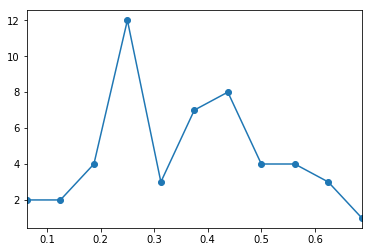

In [36]:
pd.Series(correctness).value_counts().sort_index().plot(marker='o')

In [37]:
correctness.mean()

0.35999999999999999